In [1]:
import os

%matplotlib inline
%config InlineBackend.close_figures = False

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ficus import FigureManager

sns.set()

## metagenomes (source)

In [2]:
metagenomes = pd.read_table("metagenomes_source-20200821.csv", sep=',', usecols=["Run", "size_MB"])

In [3]:
done_sigs = pd.read_table("done_sigs", sep="\t", names=["Run", "size_KB"])
done_sigs["Run"] = done_sigs["Run"].str.replace(r".*/(?P<id>\w+).sig", lambda m: m.group("id"))
done_sigs["size_MB"] = done_sigs["size_KB"] / 1024
del done_sigs["size_KB"]
done_sigs = done_sigs.set_index("Run")

In [4]:
missing_metagenomes = metagenomes.drop_duplicates(subset=["Run"]).set_index("Run").reindex(set(metagenomes["Run"]).difference(set(done_sigs.index)))
missing_metagenomes = missing_metagenomes[missing_metagenomes["size_MB"] > 0]

In [5]:
all_desc = metagenomes.describe()
print("# metagenomes")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(metagenomes['size_MB'].sum()))
print()

missing_desc = missing_metagenomes.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_metagenomes['size_MB'].sum()))
print("max:")
print(missing_metagenomes.loc[missing_metagenomes.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

# metagenomes
          size_MB
count  569,475.00
mean       812.86
std      2,731.13
min          0.00
25%          4.00
50%         28.00
75%        523.00
max    170,085.00
sum: 462,905,718.00

# missing
          size_MB
count   63,624.00
mean     3,313.25
std      5,542.37
min          1.00
25%        169.00
50%        951.00
75%      4,594.00
max    133,104.00
sum: 210,802,216.00
max:
               size_MB
Run                   
ERR3152367  133,104.00


In [6]:
all_desc = metagenomes.describe()
print("# metagenomes")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(metagenomes['size_MB'].sum()))
print()

missing_desc = missing_metagenomes.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_metagenomes['size_MB'].sum()))
print("max:")
print(missing_metagenomes.loc[missing_metagenomes.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

# metagenomes
          size_MB
count  569,475.00
mean       812.86
std      2,731.13
min          0.00
25%          4.00
50%         28.00
75%        523.00
max    170,085.00
sum: 462,905,718.00

# missing
          size_MB
count   63,624.00
mean     3,313.25
std      5,542.37
min          1.00
25%        169.00
50%        951.00
75%      4,594.00
max    133,104.00
sum: 210,802,216.00
max:
               size_MB
Run                   
ERR3152367  133,104.00


In [7]:
len(missing_metagenomes[(missing_metagenomes["size_MB"] < 3000)])

37740

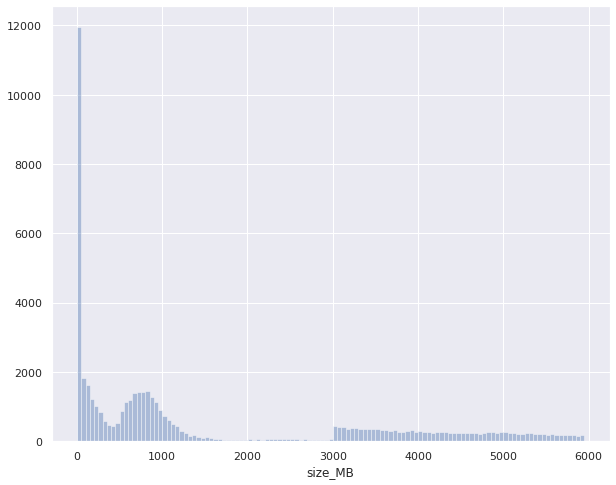

In [8]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(missing_metagenomes["size_MB"], kde=False, ax=ax, bins=range(1, 6000, 50))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

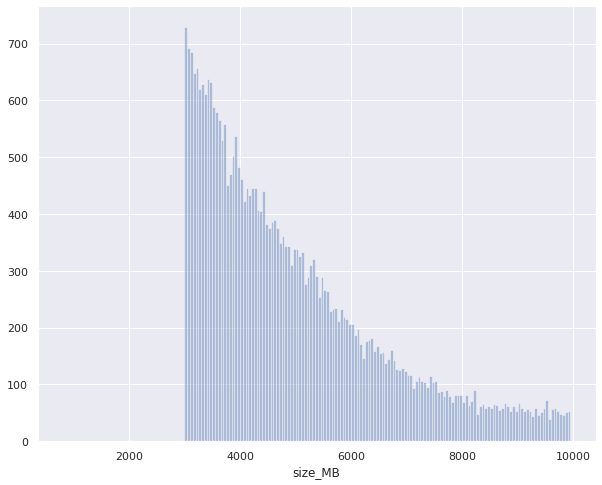

In [9]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(metagenomes["size_MB"], kde=False, ax=ax, bins=range(3000, 10000, 50))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

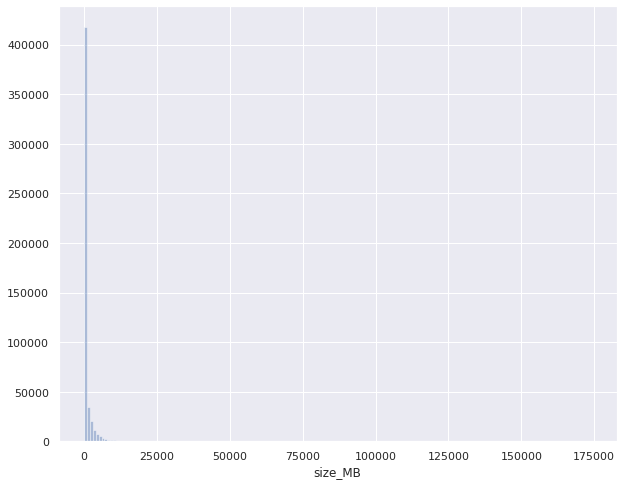

In [10]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(metagenomes["size_MB"], kde=False, ax=ax, bins=range(1, 175000, 1000))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

In [11]:
done_sigs_metagenomes = metagenomes.drop_duplicates(subset=["Run"]).set_index("Run").reindex(set(metagenomes["Run"]).intersection(set(done_sigs.index)))

In [12]:
done_sigs.reindex(done_sigs_metagenomes.index).sum()

size_MB    2.248365e+06
dtype: float64

In [13]:
import scipy
from scipy.stats import pareto
import numpy as np

In [14]:
counts, bins = np.histogram(metagenomes["size_MB"], bins=range(1, 175000, 10))

In [ ]:
b, loc, scale = pareto.fit(metagenomes["size_MB"])
b, loc, scale

/home/luizirber/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [ ]:
rv = pareto(b)

In [ ]:
#mean, var, skew, kurt
pareto.stats(b, moments='mvsk')

In [ ]:
norm_counts = counts / np.linalg.norm(counts, ord=1)

In [ ]:
with FigureManager(figsize=(10, 5), show=True) as (fig, ax):
    plt.loglog(bins[:-1], norm_counts, 'x')
    x = np.linspace(pareto.ppf(0.01, b),
                    pareto.ppf(0.99, b), 100)
    plt.loglog(bins[:-1], rv.pdf(bins[:-1]), 'r-', lw=5, alpha=0.6, label='pareto pdf')
    #plt.loglog(bins[:-1], powlaw(bins[:-1], *popt), 'o')
    #plt.loglog(bins[:-1], powlaw(bins[:-1], popt[0], -.9999999), '--')

In [ ]:
with FigureManager(figsize=(10, 5), show=True, filename="../../thesis/figure/wortMetagSizes.png") as (fig, ax):
    ar = sorted(metagenomes["size_MB"])#, reverse=True)
    y = np.cumsum(ar).astype("float32")  
    y = np.hstack((0,y))
    x = np.linspace(0, 100, y.size)
    plt.plot(x,y)
    plt.title("Cumulative sum of dataset sizes")
    plt.ylabel("cumulative size (MB)")
    plt.xlabel("percentage of total datasets (sorted by size)")

## Microbial

In [ ]:
microbial = pd.read_table("microbial_new_20200603.csv", sep=',', usecols=["Run", "size_MB"])

done_sigs = pd.read_table("done_sigs", sep="\t", names=["Run", "size_KB"])
done_sigs["Run"] = done_sigs["Run"].str.replace(r".*/(?P<id>\w+).sig", lambda m: m.group("id"))
done_sigs["size_MB"] = done_sigs["size_KB"] / 1024
del done_sigs["size_KB"]
done_sigs = done_sigs.set_index("Run")
done = microbial.set_index("Run").reindex(done_sigs.index)
done["sig size_MB"] = done_sigs["size_MB"]

missing = microbial.set_index("Run").reindex(set(microbial["Run"]).difference(set(done_sigs.index)))

In [ ]:
all_desc = microbial.describe()
print("# all")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(microbial['size_MB'].sum()))
print()

done_desc = done.describe()
print("# done")
print(done_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(done['size_MB'].sum()))
print("max:")
print(done.loc[done.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))
print()

missing_desc = missing.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing['size_MB'].sum()))
print("max:")
print(missing.loc[missing.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(missing["size_MB"], kde=False, ax=ax, bins=range(1, 5000, 100))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

In [ ]:
all_desc = microbial.describe()
print("# all")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(microbial['size_MB'].sum()))
print()

done_desc = done.describe()
print("# done")
print(done_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}  {:,.2f}".format(*done.sum()))
print("max:")
print(done.loc[done.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))
print()

missing_desc = missing.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing['size_MB'].sum()))
print("max:")
print(missing.loc[missing.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(missing["size_MB"], kde=False, ax=ax, bins=range(1, 5000, 100))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

In [ ]:
len(microbial[(microbial["size_MB"] < 10000) & (microbial["size_MB"] > 1600)])

In [ ]:
len(missing[(missing["size_MB"] < 10000) & (missing["size_MB"] > 1600)])

In [ ]:
len(missing[missing["size_MB"] > 1600])

In [ ]:
len(missing[missing["size_MB"] < 1600])

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.boxplot(data=done, y="size_MB", ax=ax)
    # sns.swarmplot(x="domain", y="21", data=plot_df, color=".2", ax=ax)
    ax.set_yscale("log")
    #ax.set_ylabel("sketch size (k=21)")

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.boxplot(data=microbial, y="size_MB", ax=ax)
    # sns.swarmplot(x="domain", y="21", data=plot_df, color=".2", ax=ax)
    ax.set_yscale("log")
    #ax.set_ylabel("sketch size (k=21)")

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.boxplot(data=done, y="sig size_MB", ax=ax)
    # sns.swarmplot(x="domain", y="21", data=plot_df, color=".2", ax=ax)
    ax.set_yscale("log")
    #ax.set_ylabel("sketch size (k=21)")

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.boxplot(data=missing, y="size_MB", ax=ax)
    # sns.swarmplot(x="domain", y="21", data=plot_df, color=".2", ax=ax)
    ax.set_yscale("log")
    #ax.set_ylabel("sketch size (k=21)")

## Not plants or animals

In [ ]:
not_plants_animals = pd.read_table("no_plants_animals_20200617.csv", sep=',', usecols=["Run", "size_MB"])

done_sigs = pd.read_table("done_sigs", sep="\t", names=["Run", "size_KB"])
done_sigs["Run"] = done_sigs["Run"].str.replace(r".*/(?P<id>\w+).sig", lambda m: m.group("id"))
done_sigs["size_MB"] = done_sigs["size_KB"] / 1024
del done_sigs["size_KB"]
done_sigs = done_sigs.set_index("Run")

In [ ]:
missing_not_plants_animals = not_plants_animals.drop_duplicates(subset=["Run"]).set_index("Run").reindex(set(not_plants_animals["Run"]).difference(set(done_sigs.index)))
missing_not_plants_animals = missing_not_plants_animals[missing_not_plants_animals["size_MB"] > 0]

In [ ]:
all_desc = not_plants_animals.describe()
print("# not plants or animals")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(not_plants_animals['size_MB'].sum()))
print()

missing_desc = missing_not_plants_animals.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_not_plants_animals['size_MB'].sum()))
print("max:")
print(missing_not_plants_animals.loc[missing_not_plants_animals.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
all_desc = not_plants_animals.describe()
print("# not plants or animals")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(not_plants_animals['size_MB'].sum()))
print()

missing_desc = missing_not_plants_animals.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_not_plants_animals['size_MB'].sum()))
print("max:")
print(missing_not_plants_animals.loc[missing_not_plants_animals.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(missing_not_plants_animals["size_MB"], kde=False, ax=ax, bins=range(1, 6500, 50))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

In [ ]:
len(missing_not_plants_animals[(missing_not_plants_animals["size_MB"] < 3000) & (missing_not_plants_animals["size_MB"] > 0)])

In [ ]:
missing_not_plants_animals[(missing_not_plants_animals["size_MB"] < 3000) & (missing_not_plants_animals["size_MB"] > 0)].sum()

In [ ]:
len(missing_not_plants_animals[(missing_not_plants_animals["size_MB"] > 3000)])

In [ ]:
missing_not_plants_animals[(missing_not_plants_animals["size_MB"] > 3000)].sum()

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(not_plants_animals["size_MB"], kde=False, ax=ax, bins=range(1, 3000, 25))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

## metagenomes

In [ ]:
metagenomes = pd.read_table("metagenomes_20200618.csv", sep=',', usecols=["Run", "size_MB"])

done_sigs = pd.read_table("done_sigs", sep="\t", names=["Run", "size_KB"])
done_sigs["Run"] = done_sigs["Run"].str.replace(r".*/(?P<id>\w+).sig", lambda m: m.group("id"))
done_sigs["size_MB"] = done_sigs["size_KB"] / 1024
del done_sigs["size_KB"]
done_sigs = done_sigs.set_index("Run")

In [ ]:
missing_metagenomes = metagenomes.drop_duplicates(subset=["Run"]).set_index("Run").reindex(set(metagenomes["Run"]).difference(set(done_sigs.index)))
missing_metagenomes = missing_metagenomes[missing_metagenomes["size_MB"] > 0]

In [ ]:
all_desc = metagenomes.describe()
print("# metagenomes")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(metagenomes['size_MB'].sum()))
print()

missing_desc = missing_metagenomes.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_metagenomes['size_MB'].sum()))
print("max:")
print(missing_metagenomes.loc[missing_metagenomes.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
all_desc = metagenomes.describe()
print("# metagenomes")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(metagenomes['size_MB'].sum()))
print()

missing_desc = missing_metagenomes.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_metagenomes['size_MB'].sum()))
print("max:")
print(missing_metagenomes.loc[missing_metagenomes.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(missing_metagenomes["size_MB"], kde=False, ax=ax, bins=range(1, 3000, 25))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(metagenomes["size_MB"], kde=False, ax=ax, bins=range(1, 3000, 25))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

## RefSeq

In [ ]:
refseq = pd.read_table("assembly_summary_refseq.txt", usecols=["# accession number", "size_MB"])

done_sigs = pd.read_table("done_sigs", sep="\t", names=["Run", "size_KB"])
done_sigs["Run"] = done_sigs["Run"].str.replace(r".*/(?P<id>\w+).sig", lambda m: m.group("id"))
done_sigs["size_MB"] = done_sigs["size_KB"] / 1024
del done_sigs["size_KB"]
done_sigs = done_sigs.set_index("Run")

In [ ]:
missing_metagenomes = metagenomes.drop_duplicates(subset=["Run"]).set_index("Run").reindex(set(metagenomes["Run"]).difference(set(done_sigs.index)))
missing_metagenomes = missing_metagenomes[missing_metagenomes["size_MB"] > 0]

In [ ]:
all_desc = metagenomes.describe()
print("# metagenomes")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(metagenomes['size_MB'].sum()))
print()

missing_desc = missing_metagenomes.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_metagenomes['size_MB'].sum()))
print("max:")
print(missing_metagenomes.loc[missing_metagenomes.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
all_desc = metagenomes.describe()
print("# metagenomes")
print(all_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(metagenomes['size_MB'].sum()))
print()

missing_desc = missing_metagenomes.describe()
print("# missing")
print(missing_desc.applymap(lambda x: "{:,.2f}".format(x)))
print("sum: {:,.2f}".format(missing_metagenomes['size_MB'].sum()))
print("max:")
print(missing_metagenomes.loc[missing_metagenomes.idxmax()].applymap(lambda x: "{:,.2f}".format(x)))

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(missing_metagenomes["size_MB"], kde=False, ax=ax, bins=range(1, 3000, 25))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)

In [ ]:
with FigureManager(figsize=(10, 8), show=True) as (fig, ax):
    sns.distplot(metagenomes["size_MB"], kde=False, ax=ax, bins=range(1, 3000, 25))
    #sns.swarmplot(data=missing, y="size_MB", color=".2", ax=ax)